In [3]:
from dotenv import load_dotenv
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

load_dotenv()

True

In [4]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

In [6]:
docs=[WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nWorkflows & agents\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\n            \n            \nThese docs will be deprecated and removed with the release of LangGraph v1.0 in October 2025. Visit the v1.0 alpha docs\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Workflows & agents\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          

In [11]:
doc_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100
)

doc_splits = text_splitter.split_documents(doc_list)

vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=HuggingFaceEmbeddings()
)

In [12]:
retriever = vectorstore.as_retriever()
retriever.invoke("What is langgraph?")

[Document(id='7ccc8cf6-f13d-4a0e-8d5b-77914df3dbe7', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='LangSmith Trace\nhttps://smith.langchain.com/public/abab6a44-29f6-4b97-8164-af77413e494d/r\nWhat LangGraph provides¶\nBy constructing each of the above in LangGraph, we get a few things:\nPersistence: Human-in-the-Loop¶\nLangGraph persistence layer supports interruption and approval of actions (e.g., Human In The Loop). See Module 3 of LangChain Academy.\nPersistence: Memory¶\nLangGraph persistence layer supports conversational (short-term) memory and long-term memory. See Modules 2 and 5 of LangChain Academy:\nStreaming¶\nLangGraph provides several ways to stream workflow / agent outputs or intermediate state. See Module 3 of LangChain Academy.\nDeployment¶\nLangGraph provides an easy on-ramp for deployment

In [13]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool=create_retriever_tool(
    retriever,
    name="retriever_vector_db_blog",
    description="Search and run information about Langgraph"
)

In [14]:
retriever_tool

Tool(name='retriever_vector_db_blog', description='Search and run information about Langgraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000002A0A15AFCE0>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002A06B1D2B10>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000002A06ED05260>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002A06B1D2B10>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_co

In [15]:
tools=[retriever_tool]

In [16]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
     messages: Annotated[Sequence[BaseMessage], add_messages]

In [18]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(
    model="openai/gpt-oss-20b",
    base_url="https://openrouter.ai/api/v1",
)

In [19]:
llm.invoke("Hello")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 75, 'total_tokens': 117, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': '', 'id': 'gen-1758122414-2xFQ9UwluANjhvI4WqBY', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--6f4de5d0-e59c-4842-8456-a824953e354a-0', usage_metadata={'input_tokens': 75, 'output_tokens': 42, 'total_tokens': 117, 'input_token_details': {}, 'output_token_details': {}})

In [20]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://openrouter.ai/api/v1",
    )
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

In [21]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

In [22]:
#EDGES

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")


    model = ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://openrouter.ai/api/v1",
    )

    llm_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [23]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    prompt = hub.pull("rlm/rag-prompt")

    model = ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://openrouter.ai/api/v1",
    )

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [24]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [25]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]
    model = ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://openrouter.ai/api/v1",
    )
    response = model.invoke(msg)
    return {"messages": [response]}

In [26]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Graph
builder = StateGraph(AgentState)

# Nodes
builder.add_node("agent",agent)
retrieve = ToolNode([retriever_tool])
builder.add_node("retrieve",retrieve)
builder.add_node("rewrite",rewrite)
builder.add_node("generate",generate)

#Edeges
builder.add_edge(START,"agent")
builder.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)
builder.add_conditional_edges(
    "retrieve",
    grade_documents,
)
builder.add_edge("generate", END)
builder.add_edge("rewrite", "agent")

#Compile
graph = builder.compile()

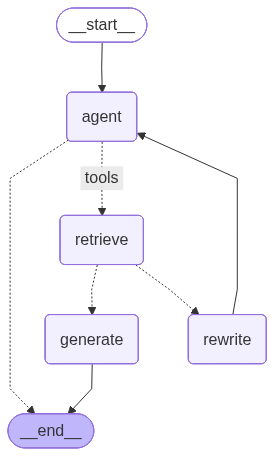

In [27]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [28]:
graph.invoke({"messages":"What is machine learning"})

---CALL AGENT---


{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='f387da3b-5ed2-483b-8923-8ca71c2d90a6'),
  AIMessage(content='**Machine learning (ML)** is a branch of artificial intelligence that teaches computers to learn from data, identify patterns, and make decisions or predictions without being explicitly programmed to perform each specific task.\n\n---\n\n## 1. The Core Idea\n\n1. **Data** – Raw information (images, text, numbers, measurements, etc.).  \n2. **Algorithm** – The mathematical “recipe” that will process the data.  \n3. **Model** – The outcome of running an algorithm on data; essentially a function that maps inputs to outputs.  \n4. **Learning** – The process of adjusting the model’s parameters to improve its predictions on new data.\n\n---\n\n## 2. How It Works (in Simple Steps)\n\n| Step | What Happens | Example |\n|------|--------------|---------|\n| **Collect data** | Gather real‑world measurements. | 10,000 photos of 

In [29]:
inputs={
    "messages": [
        ("user", "What is MAchine LEarning"),
    ]
}
for output in graph.stream(inputs):
    print(output)

---CALL AGENT---
{'agent': {'messages': [AIMessage(content='**Machine learning (ML)** is a branch of computer science that gives computers the ability to learn and make decisions or predictions from data, without being explicitly programmed for each specific task.\n\n---\n\n### How it works (in a nutshell)\n\n| Step | What happens | Example |\n|------|--------------|--------|\n| 1. **Data collection** | Gather raw information (images, text, numbers, etc.) | 100k photos of cats and dogs |\n| 2. **Preprocessing** | Clean and format the data | Resize images, remove noise |\n| 3. **Model selection** | Pick an algorithm (e.g., linear regression, neural network). | Convolutional neural network (CNN) for image classification |\n| 4. **Training** | Feed the model the data, letting it adjust internal “weights” to reduce error. | CNN learns to recognize cats in pictures |\n| 5. **Evaluation** | Test on unseen data to see how well it generalizes. | Accuracy = 95\u202f% on new cat/dog images |\n| 